In [1]:
from analytic_psfs import Mie_Theory
from analytic_psfs import Plot_Everything
import numpy as np
import matplotlib.pyplot as plt

# Vary Pump Wavelength

### Line Spectra (Evaulated at max zp)

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)
radius = np.array([10, 20, 30, 40, 50])*1E-7
ax[0].set_xlabel('Pump Wavelength [nm]')

waverange = np.round(np.arange(400, 700, 1)*1E-7, 7)
pump = waverange
probe = 785.E-7
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 500 # microWatts
zp = -1000.E-7

pe = Plot_Everything(radius)
pe.pi_si_terms(pump, probe, whichalpha, nTOT_abs, nTOT_sca, power, fig, 
               ax, plot_self_diff=False, sep_sincos=False,define_zp=np.array([zp]))


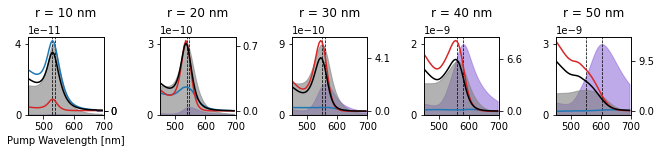

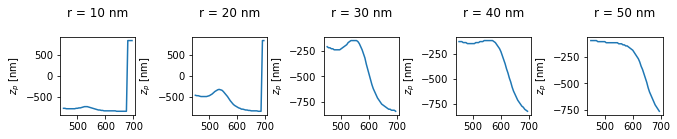

In [2]:
#### Find Max ####
fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)
radius = np.array([10, 20, 30, 40, 50])*1E-7
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 500 # microWatts

pe = Plot_Everything(radius)
waverange = np.round(np.arange(450, 700, 5)*1E-7, 7)
pump = waverange
probe = np.array([785.E-7])

pe.sweepwave_atzpmax(pump, probe, whichalpha, 
                    nTOT_abs, nTOT_sca, 
                    power, fig, ax,
                    plot_scatt_diff=False,
                    sep_sincos=False,
                    include_zpmax=True,
                    waverange=waverange)


### Spectrum Image

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4),sharex=True)
radius = 10*1E-7
waverange = np.round(np.arange(400, 700, 10)*1E-7, 7)
zp = np.arange(-2000, 2000, 20)*1E-7
pump = waverange
probe = 785.E-7
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 500 # microWatts

pe = Plot_Everything(radius)
pe.sweep_zp_image(pump, probe, whichalpha, nTOT_abs, power, fig, ax, zp)



# Vary Probe Wavelength

### Line Spectra

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)
radius = np.array([10, 20, 30, 40, 50])*1E-7

ax[0].set_xlabel('Probe Wavelength [nm]')
waverange = np.round(np.arange(400, 700, 1)*1E-7, 7)
pump = np.array([532.E-7])
probe = waverange
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 500 # microWatts
zp = 0
pe = Plot_Everything(radius)
pe.pi_si_terms(pump, probe, whichalpha, nTOT_abs, nTOT_sca, power, fig, ax, 
               plot_self_diff=False, sep_sincos=False, define_zp=np.array([zp])
              )

### Spectrum Image

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4),sharex=True)
radius = 40*1E-7
waverange = np.round(np.arange(490, 700, 10)*1E-7, 7)
zp = np.arange(-2000, 2000, 20)*1E-7
pump = np.array([532.E-7])
probe = waverange
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 500 # microWatts

pe = Plot_Everything(radius)
pe.sweep_zp_image(pump, probe, whichalpha, nTOT_abs, power, fig, ax, zp)


# Vary Both Pump and Probe

### Line Spectra

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(9.3,1.8),sharex=True)
radius = np.array([10, 20, 30, 40, 50])*1E-7
ax[0].set_xlabel('Pump and Probe Wavelength [nm]')

waverange = np.round(np.arange(450, 700, 1)*1E-7, 7)
pump = waverange
probe = waverange
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 500 # microWatts

pe = Plot_Everything(radius)
pe.pi_si_terms(pump, probe, whichalpha, nTOT_abs, nTOT_sca, power, fig, ax, 
               plot_self_diff=False, sep_sincos=False,define_zp=np.array([0*1E-7]))


### Spectrum Image

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4),sharex=True)
radius = 45*1E-7
waverange = np.round(np.arange(490, 700, 10)*1E-7, 7)
zp = np.arange(-1000, 1000, 20)*1E-7
pump = waverange
probe = waverange
whichalpha='coreshell_MW'
nTOT_abs=10
nTOT_sca=10
power = 500 # microWatts

pe = Plot_Everything(radius)
pe.sweep_zp_image(pump, probe, whichalpha, nTOT_abs, power, fig, ax, zp)


## Sweep Power

In [ ]:
from analytic_psfs import Mie_Theory
from analytic_psfs import Plot_Everything
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(2.,2.),sharex=True)
radius = np.array([10, 20, 75])*1E-7

waverange = np.round(np.arange(400, 700, 1)*1E-7, 7)
pump = np.array([532.E-7])
probe = 785.E-7
whichalpha='coreshell_MW'
nTOT_abs=10

          

waist_pr = probe * 0.6 / 1.25
nb_T0 = 1.473
zR = np.pi*waist_pr**2*nb_T0/probe
zp = np.array([-1*zR])

power_range = np.arange(0, 1001, 100) # microwatts

pe = Plot_Everything(radius,)
pe.sweep_power(pump, probe, whichalpha, 'no', nTOT_abs, power_range, zp)

fig.savefig('power.png',
    dpi=500, bbox_inches='tight'
    )
